In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import os
import cv2

In [3]:
data_dir='./Belgium_Datasets'
train_dir=data_dir+'/BelgiumTSC_Training/Training'
test_dir=data_dir+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [4]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0,116.0,118.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0,99.0,103.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0,87.0,89.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0,78.0,86.0


In [5]:
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0,116.0,118.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0,99.0,103.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0,87.0,89.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0,78.0,86.0
5,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0,106.0,115.0


In [6]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0,4591.000000,4591.000000
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0,103.220649,90.534524
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0,61.111287,50.557826
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0,11.000000,9.000000
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0,64.000000,57.000000
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0,88.000000,80.000000
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0,124.000000,111.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0,604.000000,440.000000


In [7]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 35
resize_y  = 35
num_of_channels = 3
directory = ""
Epochs=1000
train_length = len(df)

In [8]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[7]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    random.seed(42)
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        take=0
        for j in range(len(classes[i])):
            row.append(classes[i][j])
            take=take+1
            if(take>=upSampleCount):
                break
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i].copy()
            f[0][8] = angle
            row.append(f[0])
    np.random.seed(42)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[0]).crop((row[3],row[4],row[5],row[6])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[7])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


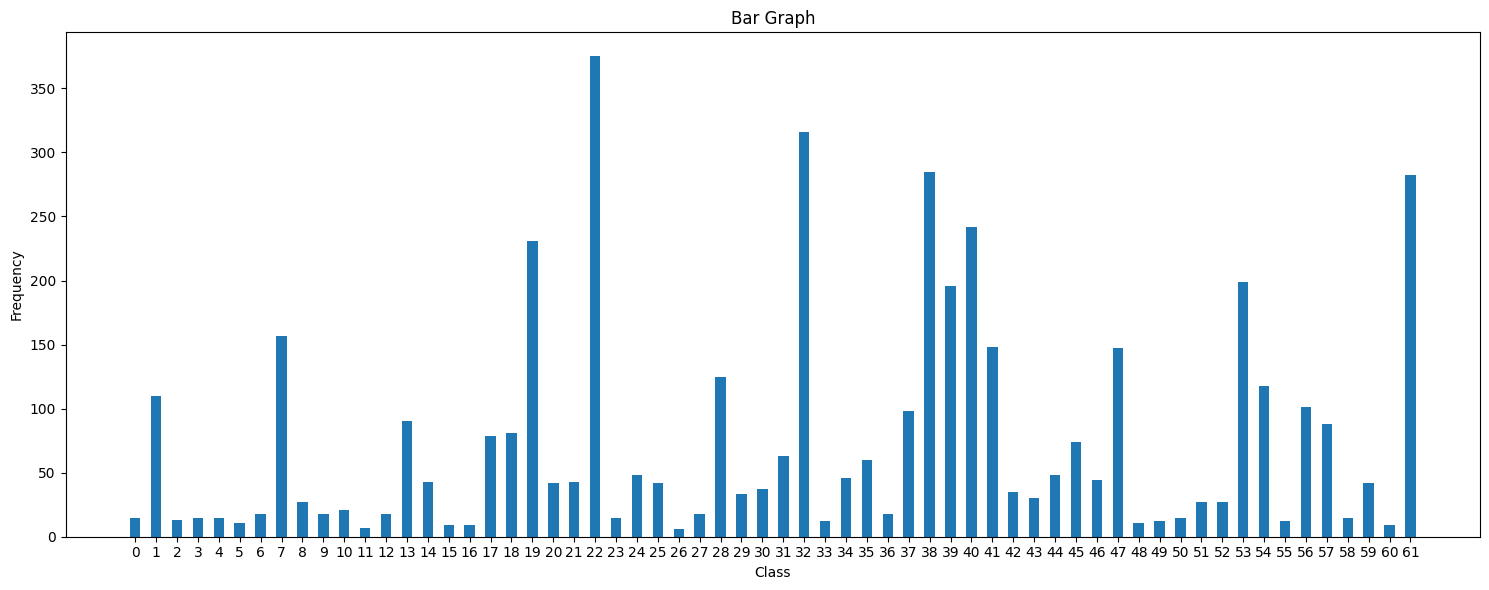

In [9]:
#Statistics of Data
viewStatistics(df)

In [10]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total number of images after Upsampling:  124000


Time taken to upsample images :  0.00863397518793742  min
Total Training Examples :  124000


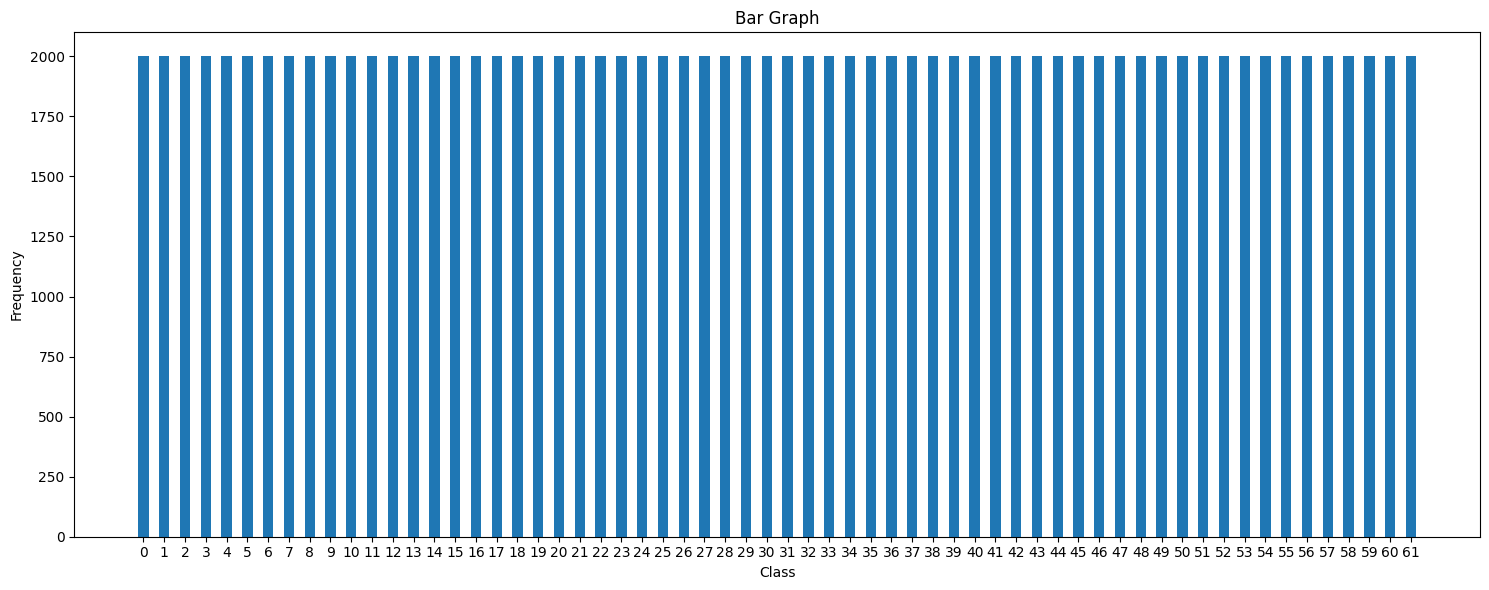

In [11]:
df = upSampleDataFrame(df,2000)
viewStatistics(df)

In [12]:
# Sample Images and there crop according to data given in csv
def resize_and_center(image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        img = img.rotate(val[8])
        # img = resize_and_center(img,resize_x,resize_y)
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [13]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
        
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image
    
    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = self.resize_and_center(img,self.resize_x,self.resize_y)
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[0],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[6],row.iloc[8]))
        self.Y.append(int(row.iloc[7]))
    
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(df)):
            row = df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])] = want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(df)):
            row = df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

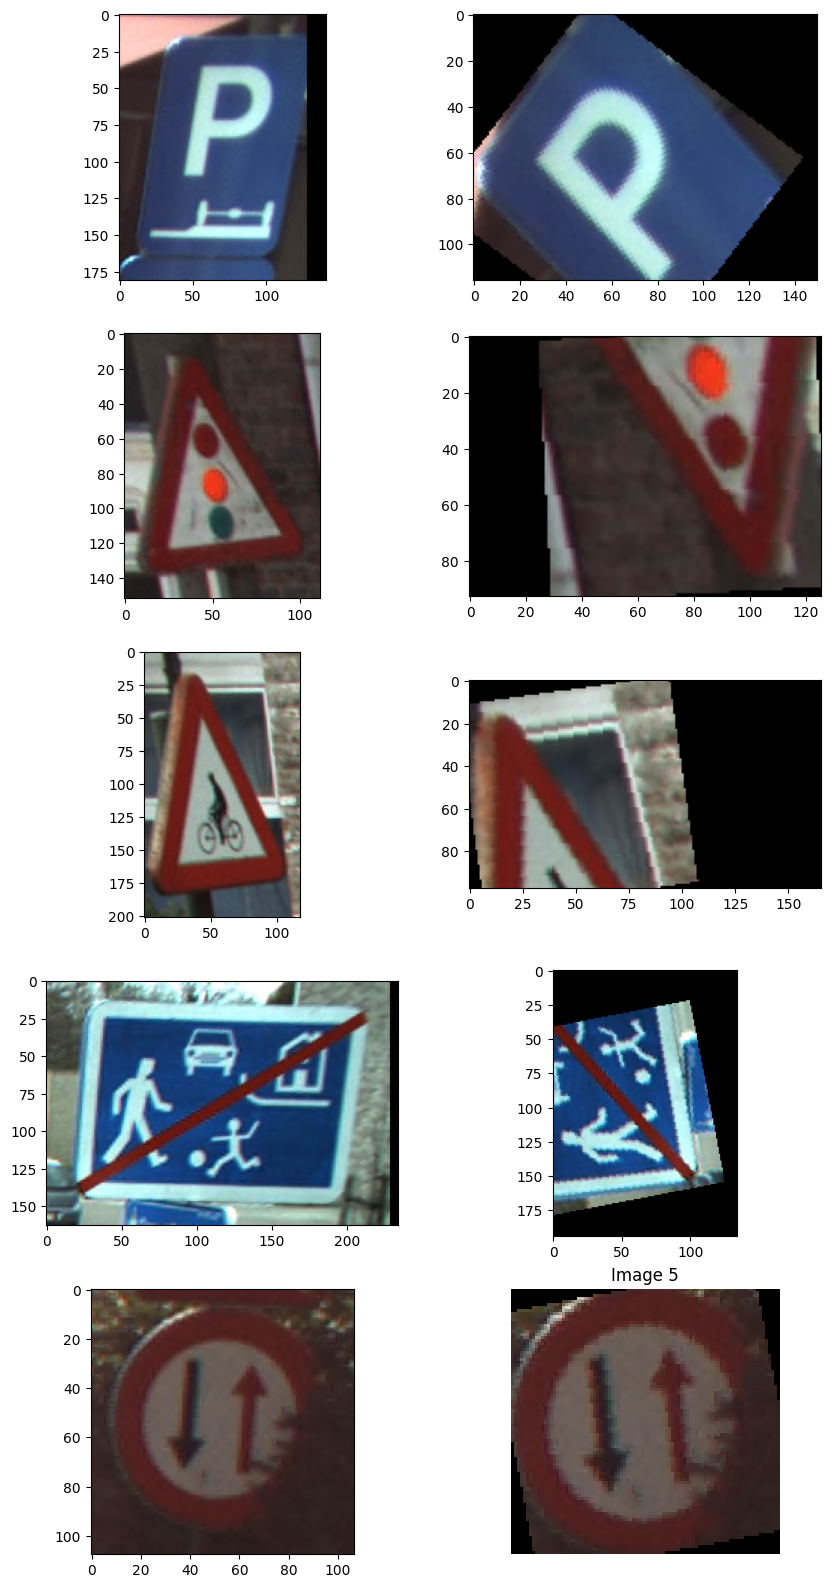

In [14]:
showExamples(df)

In [16]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  1.648658577601115  min


In [17]:
X_train = data.X
Y_train = data.Y

In [18]:
#Data_Augmentation
X_train = X_train/255.0

In [19]:
# conversion of Y_train into 2d array in order to feed CNN 
Temp = []
for i in range(len(Y_train)):
    row = [0]*num_of_classes
    row[Y_train[i]]=1
    Temp.append(np.array(row))
Y_train = np.array(Temp)

In [8]:
model = Sequential()
model.add(VGG19(weights=None, include_top=False, input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))
# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 1, 1, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 43)                44075     
                                                                 
Total params: 20595819 (78.57 MB)
Trainable params: 20594795 (78.56 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.2,verbose=0)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Accuracy : ",history.history['accuracy'][Epochs-1])
print("Time taken fit : ",total_time," min")

Accuracy :  100.0%
Time taken fit :  118.5696989250183105  min


 ***Test Image Classification and Accuracy Calculation***

In [28]:
df_test=[[]]
df_test=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,148.0,103.0,12.0,9.0,136.0,93.0,44.0,0,124.0,84.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,152.0,112.0,13.0,9.0,139.0,102.0,11.0,0,126.0,93.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,263.0,130.0,22.0,11.0,241.0,118.0,61.0,0,219.0,107.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,56.0,8.0,5.0,89.0,50.0,55.0,0,81.0,45.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,144.0,130.0,12.0,11.0,131.0,119.0,36.0,0,119.0,108.0


In [29]:
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,148.0,103.0,12.0,9.0,136.0,93.0,44.0,0,124.0,84.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,152.0,112.0,13.0,9.0,139.0,102.0,11.0,0,126.0,93.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,263.0,130.0,22.0,11.0,241.0,118.0,61.0,0,219.0,107.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,97.0,56.0,8.0,5.0,89.0,50.0,55.0,0,81.0,45.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,144.0,130.0,12.0,11.0,131.0,119.0,36.0,0,119.0,108.0


Total Training Examples :  124000


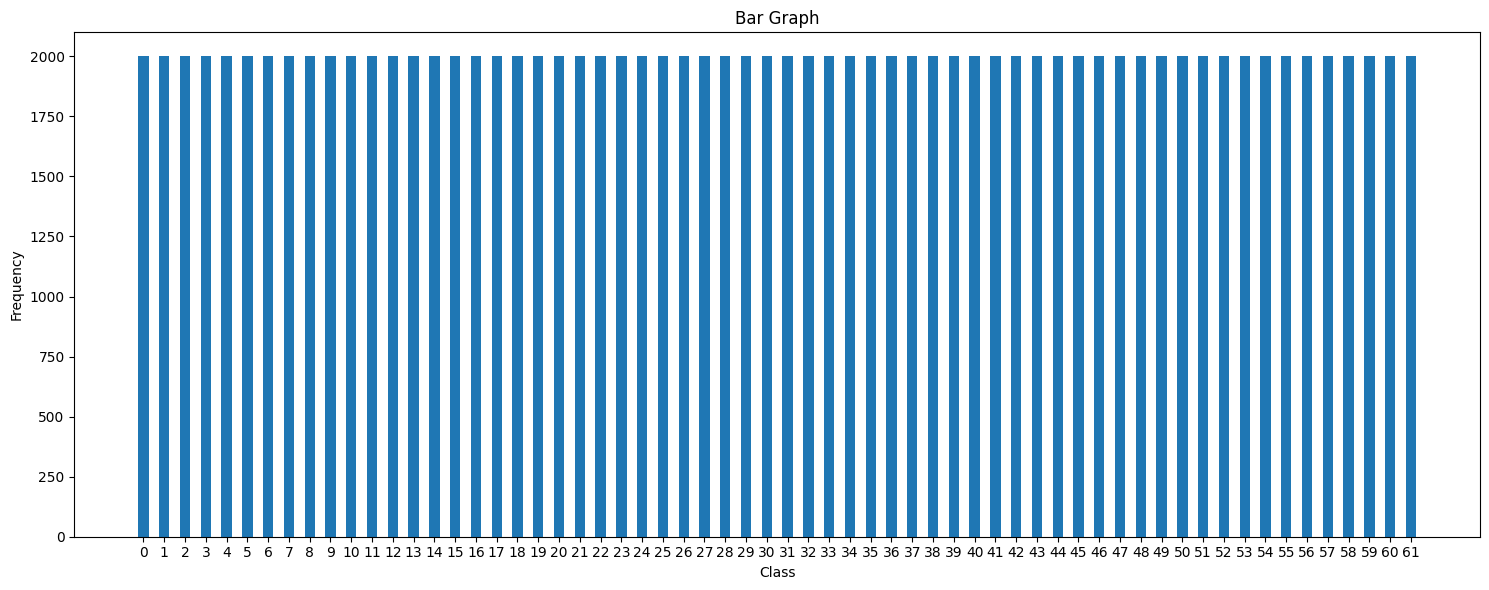

Total Training Examples :  124000


In [30]:
viewStatistics(df_test)
print("Total Training Examples : ",len(df_test))

In [ ]:
# showExamples(df_test)
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.0
mean,147.571613,136.564097,12.388000,11.486516,134.688903,124.572258,30.500000,0.0
std,72.190028,75.884213,5.953661,6.273086,66.233094,69.667800,17.895819,0.0
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0
25%,93.000000,74.000000,8.000000,6.000000,84.000000,67.000000,15.000000,0.0
50%,134.000000,118.000000,11.000000,10.000000,123.000000,108.000000,30.500000,0.0
75%,193.000000,171.000000,16.000000,14.000000,177.000000,156.000000,46.000000,0.0
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0


In [31]:
df_test = upSampleDataFrame(df_test,750)

Total number of images after Upsampling:  46500


Time taken to upsample images :  0.07813399235407512  min


In [32]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.000000,46500.0,46500.000000,46500.000000
mean,149.400473,138.271011,12.531613,11.616258,136.381118,126.129398,30.500000,0.0,123.849505,114.513140
std,72.902024,77.177135,6.024992,6.404698,66.883805,70.830935,17.895723,0.0,60.870511,64.437041
min,25.000000,22.000000,5.000000,5.000000,19.000000,16.000000,0.000000,0.0,14.000000,11.000000
25%,93.000000,74.000000,8.000000,6.000000,84.000000,67.000000,15.000000,0.0,76.000000,61.000000
50%,134.000000,118.000000,11.000000,10.000000,123.000000,108.000000,30.500000,0.0,112.000000,98.000000
75%,199.000000,182.000000,17.000000,15.000000,181.000000,166.000000,46.000000,0.0,164.000000,151.000000
max,674.000000,529.000000,56.000000,44.000000,618.000000,484.000000,61.000000,0.0,562.000000,440.000000


In [33]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df_test)

1454/1454 [==============================] - 50s 34ms/step


In [34]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  97.7629032258064515

Confusion Matrix:
 [[750   0   0 ...   0   0   0]
 [0   279   0 ...   0   0   0]
 [0   0   94 ...   47   42   0]
 ...
 [0   0   0 ...   128   0   0]
 [0   0   0 ...   0   50   0]
 [0   0   0 ...   52   48   0]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.79,1.00,0.88,375
1,1,0.89,0.74,0.81,375
2,2,0.90,1.00,0.95,375
3,3,0.90,0.86,0.88,375
4,4,1.00,1.00,1.00,375
5,5,0.98,0.89,0.93,375
6,6,0.91,0.98,0.94,375
7,7,1.00,1.00,1.00,375
8,8,0.97,0.80,0.88,375
9,9,1.00,1.00,1.00,375


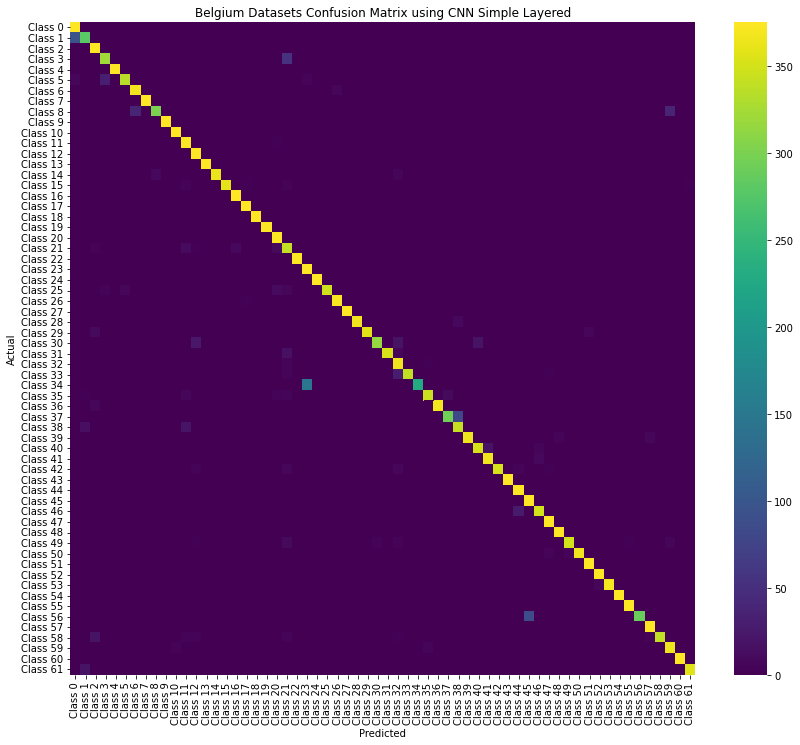

In [36]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Belgium Datasets Confusion Matrix using CNN Simple Layered')
plt.show()